# Introduction
이번에는 kaggle 타이타닉 노트북 중 <Introduction to Ensembling/Stacking in Python> 이란 이름으로 Anisotropic 이 작성한 노트북을 공부해보자. 이 노트북은 2020년 1월 7일 기준 561,810회의 조회수와 5,174의 투표를 받은 노트북으로 앞선 노트북과의 차이점은 스태킹 기법을 사용한다는 점이다.
스태킹에 대한 설명이 잘 되어있는 노트북
Stacking Starter : by Faron

In [1]:
import pandas as pd # 0.25.1
import numpy as np # 1.18.5
import re # 2020.6.8
import sklearn # 0.23.1
import xgboost as xgb # 1.3.0.post0
import seaborn as sns # 0.10.1
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py # 4.13.0
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold

**plotly** 시각화 모듈 중 손꼽히는 예쁜 모듈이라고 한다. [plotly 사이트](https://plotly.com/python/)  
`import re` 는 regex의 뜻으로 정규표현식을 의미한다. `import plotly.offline as py` 이건 말그대로 오프라인에서 사용하기 위해 작성

# Feature Exploration, Engineering and Cleaning
데이터를 탐색하고, 피처 엔지니어링을 진행하고 카테고리형 피처를 숫자형으로 인코딩해보자.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering
이 노트북은 설명이 좀 부실해보인다. 대부분 참고 링크를 걸어 여러개의 노트북을 읽어봐야하는 것으로 보인다.  
피쳐 엔지니어링을 참고한 노트북  
[Titanic Best Working Classfier](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier) : by Sina

In [3]:
full_data = [train, test]

# 이름 길이를 지정
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Cabin이 있는지 없는지 설정
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# SibSp와 Parch를 합쳐 FamilySize 만들기
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# FamilySize가 1이면 IsAlone이 1
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
# Embarked의 Null 값 S로 채우기
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Fare의 Null 값 채우기 및 CategoricalFare 만들기
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# CategoricalAge 만들기
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# 승객의 이름에서 Title을 추출하는 함수
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

# Title 만들기
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    
# 일반적이지 않은 Title을 Rare로 설정
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace([
        'Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir',
        'Jonkheer', 'Dona'
    ], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mile', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# 피처 매핑
for dataset in full_data:
    # Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Title
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
    
    # Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454),
                'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31),
                'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Age
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

## Feature Drop

In [4]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

모든 피처를 정리하고 정보를 추출하고 필요없는 피처를 삭제했으므로 이제 모든 피처는 숫자형으로 머신 러닝 모델에 적용하기 적합해졌다. 먼저 상관 관계와 분포도로 데이터 셋을 관찰해보자.
## Visualisations

In [5]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0
3,1,1,0,2,0,3,0,44,1,2,0,3.0
4,0,3,1,2,0,1,0,24,0,1,1,1.0


### Pearson Correlation Heatmap
피처들의 상관관계에 대해 알아보자.

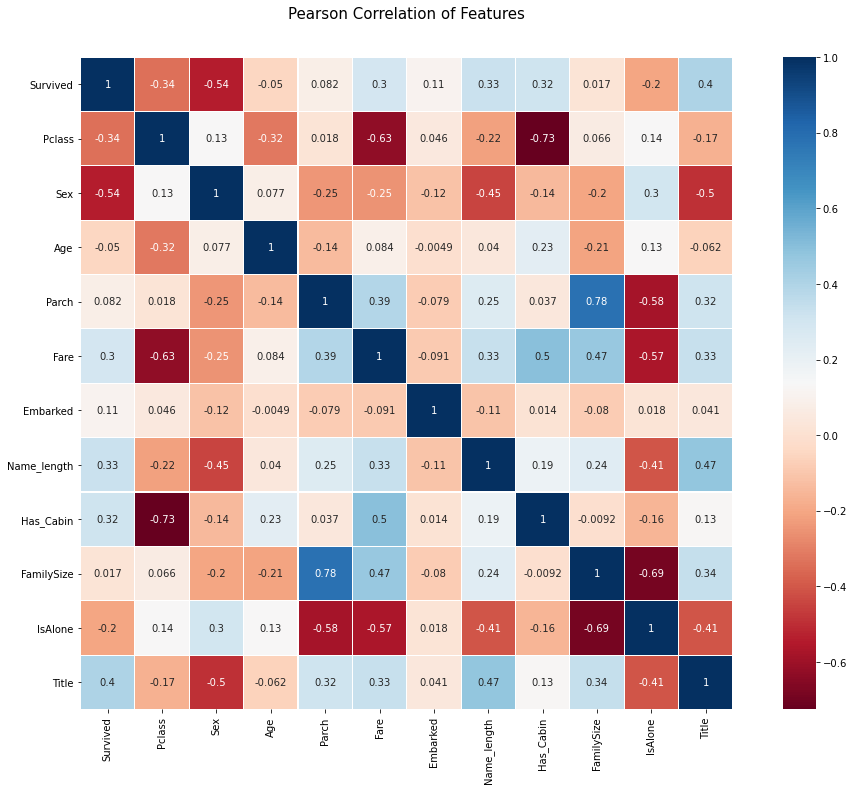

In [6]:
plt.figure(figsize=(18, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap='RdBu', linecolor='white', annot=True)


각 피처간 상관관계가 높게 나타나지않는 것은 머신러닝 모델에 적용하기 좋다는 것을 의미한다.
### Pairplot

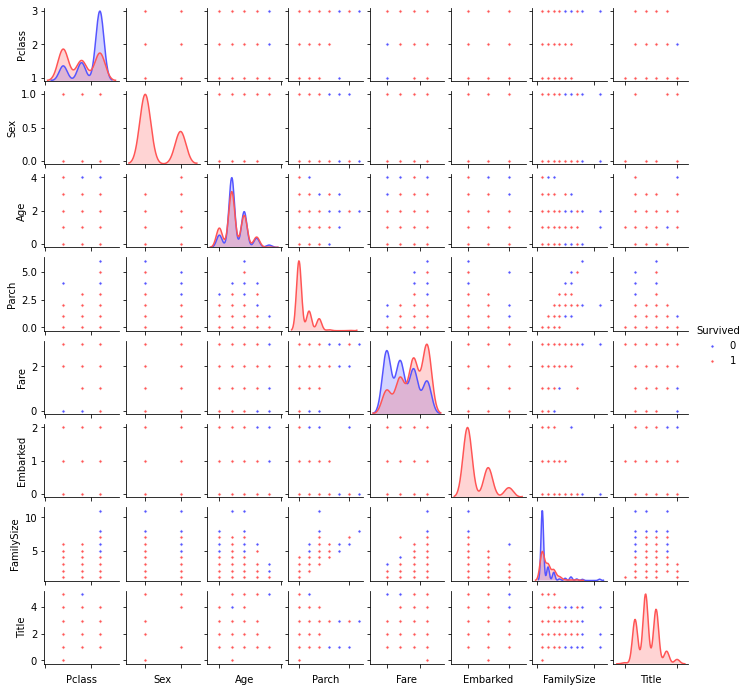

In [7]:
g = sns.pairplot(train[['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

# Ensembling & Stacking Models
## SklearnHelper class
다섯 개의 분류기를 사용하려하는데 매번 적용하기 번거로우므로 클래스를 만든다.

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

class SKlearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.fit(x, y).feature_importances_

## Out of Fold Prediction

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_train, y_train)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating Base First-Level Model
다섯 개의 분류기를 준비한다.  
1. Random Forest Classifier
2. Extra Trees Classifier
3. AdaBoost Classifier
4. Gradient Boosting Classifier
5. Suppor Vector Machine

### Classifier's  Parameters
- n_jobs: 학습에 사용할 코어의 갯수, -1이면 모든 코어를 사용한다.
- n_estimators: 학습 모델의 트리 갯수, 디폴트는 10개
- max_depth: 최대 트리 갯수, 너무 깊어지면 과적합이 발생할 수 있다.
- verbose: 학습 과정을 나타낼 것인지 설정, 0은 안나타냄, 1은 간략한 설명, 2는 자세한 설명

In [10]:
# Random Forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [11]:
rf = SKlearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SKlearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SKlearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SKlearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SKlearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [12]:
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

### Output of the First Level Predictions
앞서 만든 `get_oof()` 함수로 학습 및 예측을 한다.

In [13]:
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vector Classifier

In [14]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

In [20]:
cols = train.columns.values
feature_dataframe = pd.DataFrame({'features': cols,
                                 'Extra Trees Feature Importances': et_feature,
                                 'Random Forest Feature Importances': rf_feature,
                                 'Adaboost Feature Importances': ada_feature,
                                 'Gradient Boost Feature Importances': gb_feature}
                                )

### Feature Importances via Plotly Scatterplots

In [21]:
feature_dataframe

,features,Extra Trees Feature Importances,Random Forest Feature Importances,Adaboost Feature Importances,Gradient Boost Feature Importances
0,Pclass,0.122616,0.113798,0.028,0.089393
1,Sex,0.393482,0.244518,0.012,0.028691
2,Age,0.027441,0.031507,0.014,0.044002
3,Parch,0.016741,0.020320,0.064,0.013022
4,Fare,0.056243,0.048306,0.040,0.049732
5,Embarked,0.028111,0.022892,0.010,0.023616
6,Name_length,0.049112,0.112131,0.690,0.179061
7,Has_Cabin,0.084899,0.067908,0.012,0.043745
8,FamilySize,0.042085,0.066813,0.054,0.109821
9,IsAlone,0.021816,0.012183,0.002,0.008181


원래 노트북은 4개의 중복된 내용들을 포함하고 있어서 함수로 만들고 for문을 돌려보았다.

In [22]:
def draw_graph(clf, features):
    trace = go.Scatter(y = feature_dataframe[clf].values,
                      x = feature_dataframe[features].values,
                      mode='markers',
                      marker=dict(sizemode='diameter',
                                 sizeref=1,
                                 size=25,
                                 color=feature_dataframe[clf].values,
                                 colorscale='Portland',
                                 showscale=True
                                 ),
                      text = feature_dataframe[features].values
                      )
    data = [trace]
    
    layout = go.Layout(autosize=True,
                      title=clf,
                      hovermode='closest',
                      yaxis=dict(title='Feature Importance',
                                ticklen=5,
                                gridwidth=2
                                ),
                      showlegend=False
                      )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')

In [23]:
for i in range(1, 5):
    draw_graph(feature_dataframe.columns[i], feature_dataframe.columns[0])

4개의 분류기에서 나온 피쳐 중요도의 평균을 만든다.

In [24]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Extra Trees Feature Importances,Random Forest Feature Importances,Adaboost Feature Importances,Gradient Boost Feature Importances,mean
0,Pclass,0.122616,0.113798,0.028,0.089393,0.088452
1,Sex,0.393482,0.244518,0.012,0.028691,0.169673
2,Age,0.027441,0.031507,0.014,0.044002,0.029238


### Feature Importances mean via Bar plot

In [25]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [
    go.Bar(x=x,
           y=y,
           width=0.5,
           marker=dict(color=feature_dataframe['mean'].values,
                       colorscale='Portland',
                       showscale=True,
                       reversescale=False),
           opacity=0.6)
]

layout = go.Layout(autosize=True,
                   title='Barplots of Mean Feature Importance',
                   hovermode='closest',
                   yaxis=dict(title='Feature Importance',
                              ticklen=5,
                              gridwidth=2),
                   showlegend=False)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

## Second-Level Predictions

In [26]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                      'ExtraTree': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'GradientBoost': gb_oof_train.ravel()})
base_predictions_train.head()

,RandomForest,ExtraTree,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training Set

In [27]:
data = [
    go.Heatmap(z=base_predictions_train.astype(float).corr().values,
               x=base_predictions_train.columns.values,
               y=base_predictions_train.columns.values,
               colorscale='Viridis',
               showscale=True,
               reversescale=True,
              )
]
py.iplot(data, filename='labelled-heatmap')

In [28]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

### Second Level Learning Model via XGBoost

In [30]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                        max_depth=4,
                        min_child_weight=2,
                        gamma=0.9,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='binary:logistic',
                        nthread=-1,
                        scale_pos_weight=1,
                        verbosity=0).fit(x_train, y_train)
predictions = gbm.predict(x_test)

# Submission

In [31]:
stackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                  'Survived': predictions})
stackingSubmission.to_csv('stackingSubmission_02.csv', index=False)